In [261]:
library(tidyverse)
library(dplyr)
library(ggplot2)
library(lubridate)
install.packages("caret")
library(caret)
options(scipen = 999)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [262]:
#Read csv data
txnlogsDec17 <- read.csv("https://raw.githubusercontent.com/naiduizm/BIA652/main/data%20files/POS_transactions_20171207-20171219.csv", sep = ",")
txnlogsFeb19 <- read.csv("https://raw.githubusercontent.com/naiduizm/BIA652/main/data%20files/POS_transactions_20190213-20190226.csv", sep = ",")
txnlogsMarApr19 <- read.csv("https://raw.githubusercontent.com/naiduizm/BIA652/main/data%20files/POS_transactions_20190328-20190410.csv", sep = ",")

In [263]:
#Combine all data
txnlogs <- rbind(txnlogsDec17, txnlogsFeb19, txnlogsMarApr19)

In [264]:
#Creating independent date and time variables for easier analysis

library(lubridate)
txnlogs$BeginDateTime <- ymd_hms(txnlogs$BeginDateTime)
txnlogs$EndDateTime <- ymd_hms(txnlogs$EndDateTime)

# Create variables for month, day, year, hour, minute, and second
txnlogs$month <- month(txnlogs$BeginDateTime)
txnlogs$day <- day(txnlogs$BeginDateTime)
txnlogs$year <- year(txnlogs$BeginDateTime)
txnlogs$DayOfWeek <- weekdays(as.Date(txnlogs$BeginDateTime, "%m/%d/%Y"))


txnlogs$Beginhour <- hour(txnlogs$BeginDateTime)
txnlogs$Beginminute <- minute(txnlogs$BeginDateTime)
txnlogs$Beginsecond <- second(txnlogs$BeginDateTime)


txnlogs$Endhour <- hour(txnlogs$EndDateTime)
txnlogs$Endminute <- minute(txnlogs$EndDateTime)
txnlogs$Endsecond <- second(txnlogs$EndDateTime)



In [265]:
#Recode month variable for easier analysis
txnlogs <- txnlogs %>% 
  mutate(month = recode_factor(month, "2" = "February", 
                        "3" = "March",
                        "4" = "April",
                        "12" = "December"))
  levels(txnlogs$month) 

[1] "February" "March"    "April"    "December"

In [266]:
# Create combined variable for month and year
txnlogs$monthYear <- paste0(year(txnlogs$BeginDateTime), "-", month(txnlogs$BeginDateTime))


In [267]:
#Factorize year, and monthYear columns

txnlogs$year <- as.factor(txnlogs$year)
txnlogs$monthYear <-as.factor(txnlogs$monthYear)
txnlogs$DayOfWeek <- as.factor(txnlogs$DayOfWeek)

In [268]:
#Create new time of day variable
txnlogs <- txnlogs %>%
  mutate(timeofDay = case_when(
    hour(BeginDateTime) >= 6 & hour(BeginDateTime) < 12 ~ "Morning",
    hour(BeginDateTime) >= 12 & hour(BeginDateTime) < 18 ~ "Afternoon",
    hour(BeginDateTime) >= 18 & hour(BeginDateTime) < 24 ~ "Evening",
    hour(BeginDateTime) >= 0 & hour(BeginDateTime) < 6 ~ "Late night"
  ))

In [269]:
#Create a new factorized checkout type variable
txnlogs <- txnlogs %>% mutate(checkoutType = as.factor(WorkstationGroupID))

In [270]:
#Create a report friendly checkout type variable and recode the levels 
txnlogs <- txnlogs %>% 
  mutate(checkoutType = recode_factor(WorkstationGroupID, '1' = "Full Service", '8' = "Self Checkout"))
  levels(txnlogs$checkoutType) 

[1] "Full Service"  "Self Checkout"

In [271]:
#Create a new payment type variable and conditionalize values of the variable to Card, Cash, Both and NA.
txnlogs <- txnlogs %>%  mutate(PaymentType = case_when(
                          TNcard == FALSE & TNcash == TRUE ~ 'Cash',
                           TNcash == FALSE & TNcard == TRUE ~ 'Card',
                           TNcash == TRUE & TNcard == TRUE ~ 'Both',
                           TRUE ~ 'NA'))

In [ ]:
#These results show that there are are rows which have transaction values even though their payment type = NA which have amounts associated.
txnlogs %>% filter(PaymentType == 'NA')

In [273]:
#Drop NA values for Payment type because it doesn't make sense to have a transaction with an amount which has no payment type associated
txnlogs <- txnlogs %>% filter(PaymentType != "NA")

In [274]:
#This frequency table confirms rows with NA payment types were dropped
table(txnlogs$PaymentType)


 Both  Card  Cash 
  708 77538 83779 

Analysis and Visualization (Numerical Variables)

In [275]:
#Summary of Amount variable. 
summary(txnlogs$Amount)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.08   21.05   45.95   72.65   93.11 6883.50 

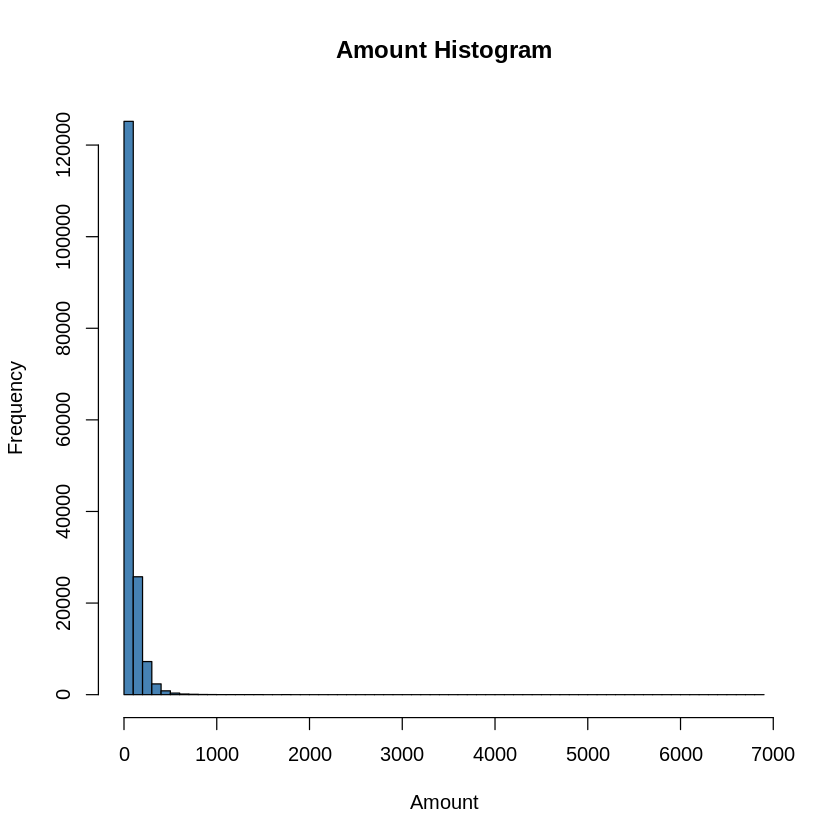

In [276]:
#Distribution of amount variable. Distribution heavily skewed to the right
hist(txnlogs$Amount, col = "steelblue", main = "Amount Histogram", xlab = "Amount", breaks = 50)


In [277]:
#Shows that December 2017 holds more occurences of higher amount values followed by Feb 2019. The median was chosen as a filter to show higher amount values
txnlogs %>%
  filter(Amount > 45.95) %>%
  group_by(monthYear) %>%
  summarise(count = n()) %>%
  mutate(percentage = (count / sum(count)) * 100)


monthYear,count,percentage
<fct>,<int>,<dbl>
2017-12,34020,41.995334
2019-2,22565,27.854930
2019-3,8005,9.881618
2019-4,16419,20.268118


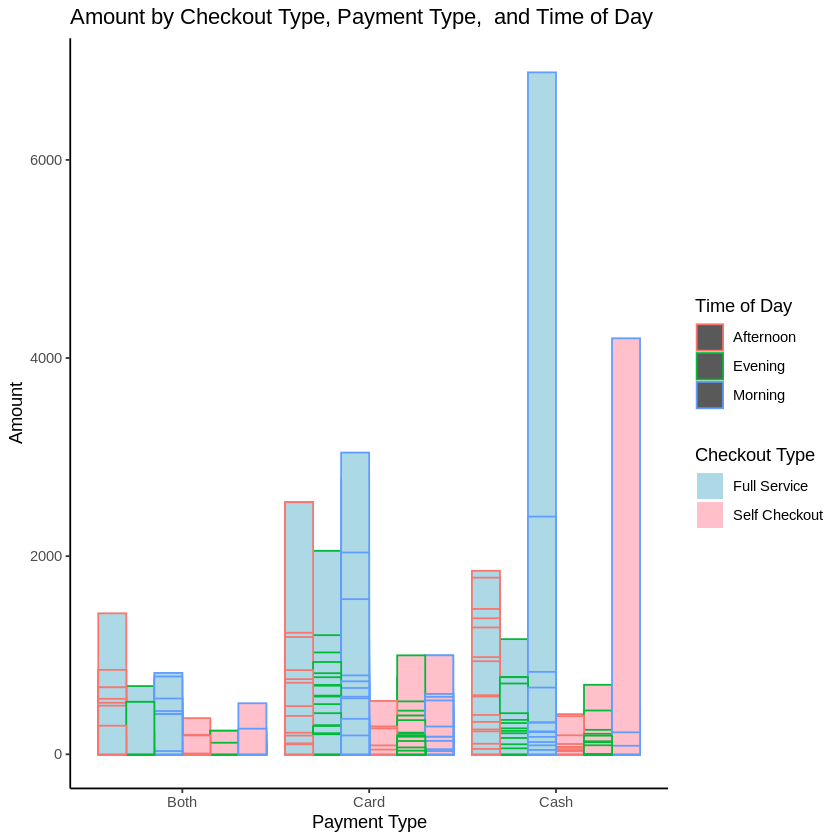

In [310]:
ggplot(txnlogs, aes(x = PaymentType, y = Amount, fill = checkoutType, color = timeofDay)) +
  geom_bar(stat = "identity", position = position_dodge()) +
  scale_fill_manual(values = c("light blue", "pink")) +
  labs(title = "Amount by Checkout Type, Payment Type,  and Time of Day ",
       x = "Payment Type", y = "Amount",
       fill = "Checkout Type", color = "Time of Day", size = 50) +
  theme_classic()


In [201]:
#Descriptive statistics of Transaction time variable (before transformation)
summary(txnlogs$TranTime)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00   31.00   55.00   71.48   93.00 1137.00 

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Warning message:
“Removed 152 rows containing non-finite values (`stat_bin()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_bar()`).”


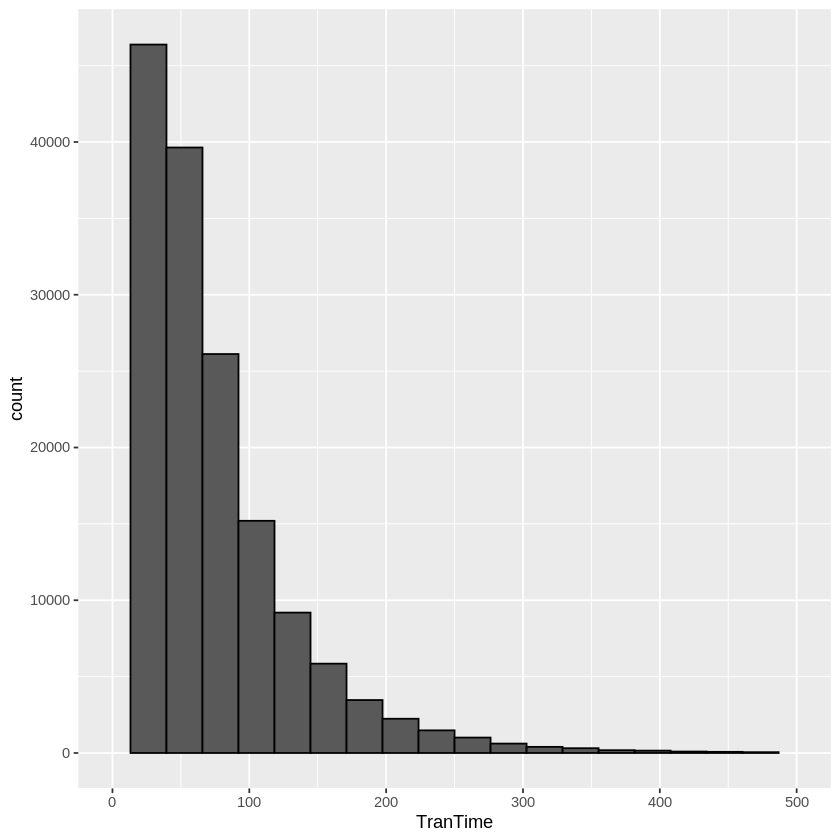

In [202]:
#Distribution of Transaction Time in seconds. Distribution heavily skewed to right
ggplot(txnlogs, aes(TranTime)) +  geom_histogram(bins=20, color = "black")  + scale_x_continuous(0, 500, 25) + xlim(0,500)


In [283]:
#Since the transaction time is a dependent variable and it looks skewed to the right. Lets normalize it using log transformation but before doing so lets offset the transactions by adding a value of 10.
txnlogs$logTranTime <- log(txnlogs$TranTime)


In [207]:
#Descriptive statistics of log transformed Transaction time
summary(txnlogs$logTranTime)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   3.434   4.007   3.959   4.533   7.036 

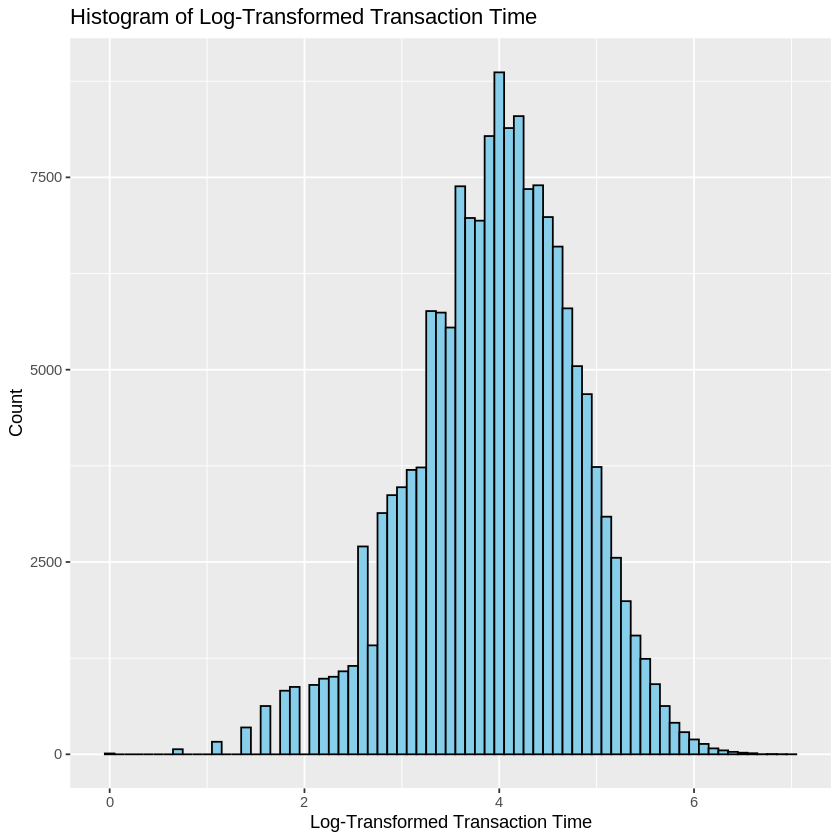

In [205]:
ggplot(txnlogs, aes(x = logTranTime)) +
  geom_histogram(binwidth = 0.1, color = "black", fill = "skyblue") +
  labs(title = "Histogram of Log-Transformed Transaction Time",
       x = "Log-Transformed Transaction Time",
       y = "Count")


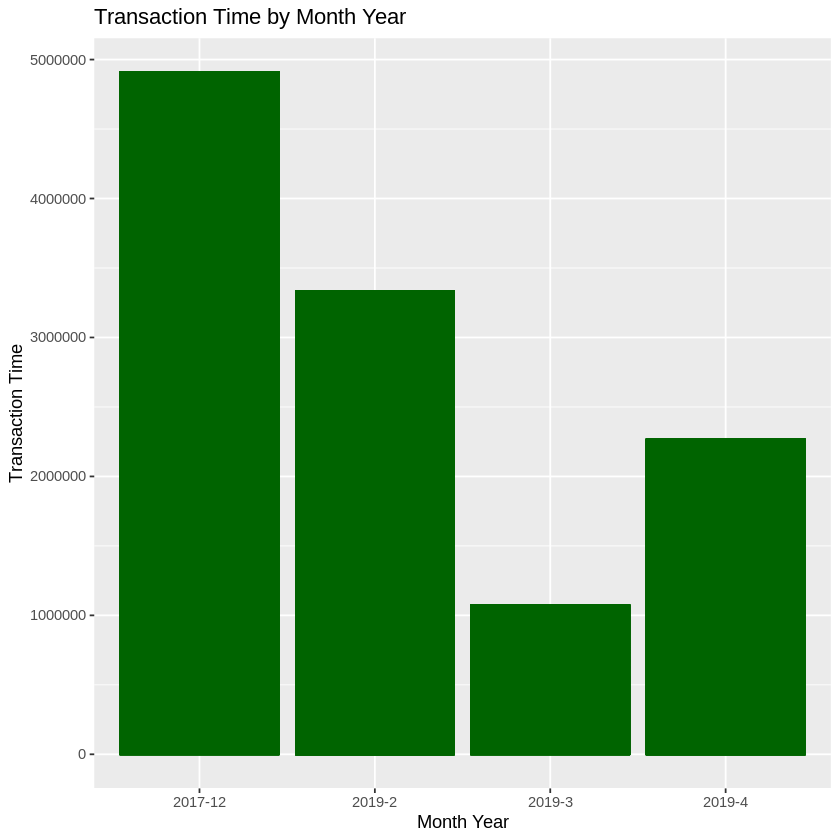

In [69]:
ggplot(txnlogs, aes(x = monthYear, y = TranTime)) +
  geom_bar(stat = "identity", fill = "steelblue3", color = "darkgreen") +
  ggtitle("Transaction Time by Month Year") +
  xlab("Month Year") +
  ylab("Transaction Time")


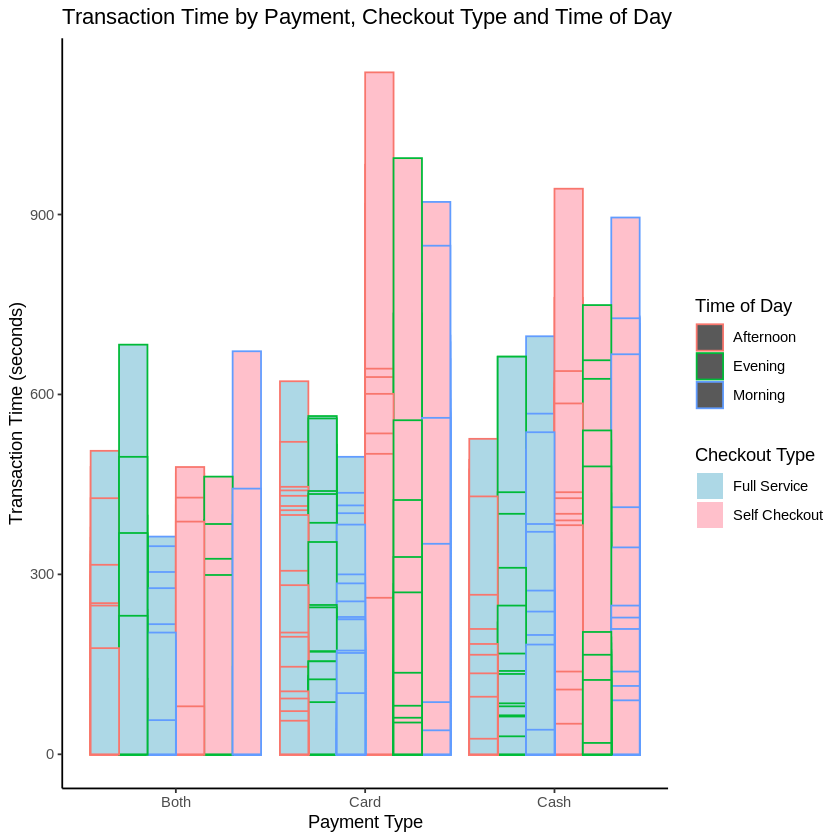

In [45]:
ggplot(txnlogs, aes(x = PaymentType, y = TranTime, fill = checkoutType, color = timeofDay)) +
  geom_bar(stat = "identity", position = position_dodge()) +
  scale_fill_manual(values = c("light blue", "pink")) +
  labs(title = "Transaction Time by Payment, Checkout Type and Time of Day ",
       x = "Payment Type", y = "Transaction Time (seconds)",
       fill = "Checkout Type", color = "Time of Day", size = 50) +
  theme_classic()


In [206]:
#Summary of BreakTime variable.  
summary(txnlogs$BreakTime)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -12.00   13.00   21.00   41.88   40.00 1199.00 

In [208]:
#Since time cannot have negative values. Lets remove the negative values so the minimum value is 0 seconds
txnlogs <- txnlogs[txnlogs$BreakTime >= 0, ]

In [210]:
#Due to outliers, median was chose as a threshold to observe which months showed breaktimes above median value of 21 secs.
library(dplyr)

txnlogs %>%
  filter(BreakTime > 21) %>%
  group_by(monthYear) %>%
  summarise(count = n()) %>%
  mutate(percentage = (count / sum(count)) * 100)


monthYear,count,percentage
<fct>,<int>,<dbl>
2017-12,28977,36.88941
2019-2,23111,29.42165
2019-3,8285,10.54729
2019-4,18178,23.14165


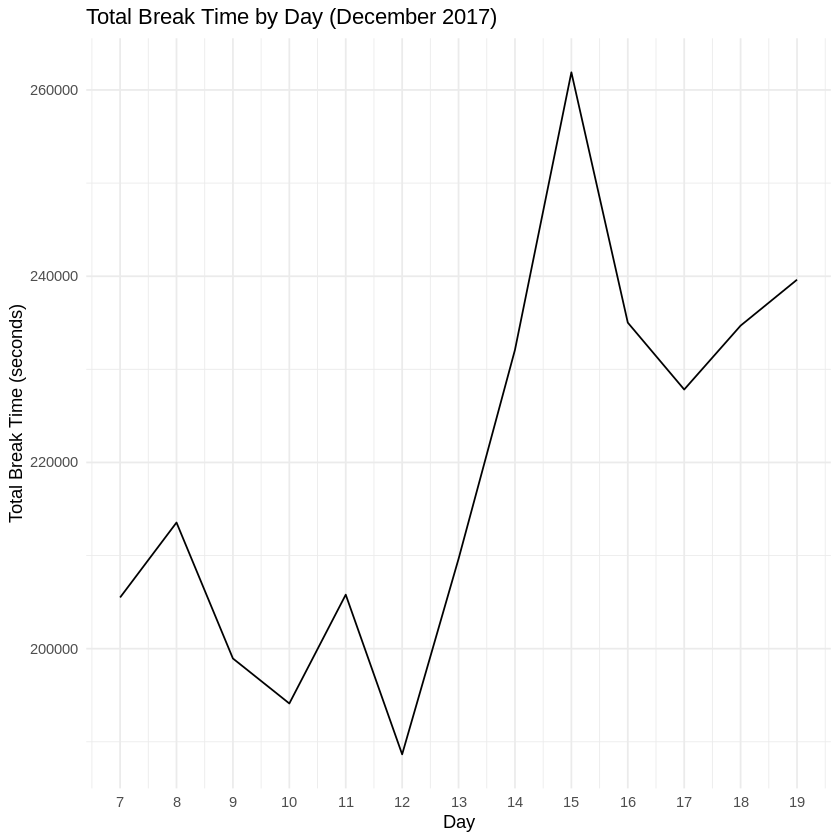

In [223]:
#This drills down to a day by day trend of break time in December 2017 as there were high break times in this month

# filter data for December 2017
decemberData <- txnlogs %>% 
  filter(monthYear == "2017-12")

# calculate total break time by day
break_time_by_day <- decemberData %>%
  group_by(day) %>%
  summarise(total_break_time = sum(BreakTime))

# plot line graph
ggplot(break_time_by_day, aes(x = day, y = total_break_time)) +
  geom_line() +
  labs(title = "Total Break Time by Day (December 2017)",
       x = "Day",
       y = "Total Break Time (seconds)") +
  theme_minimal()+
scale_x_continuous(breaks = seq(1, 31, by = 1), labels = seq(1, 31, by = 1))


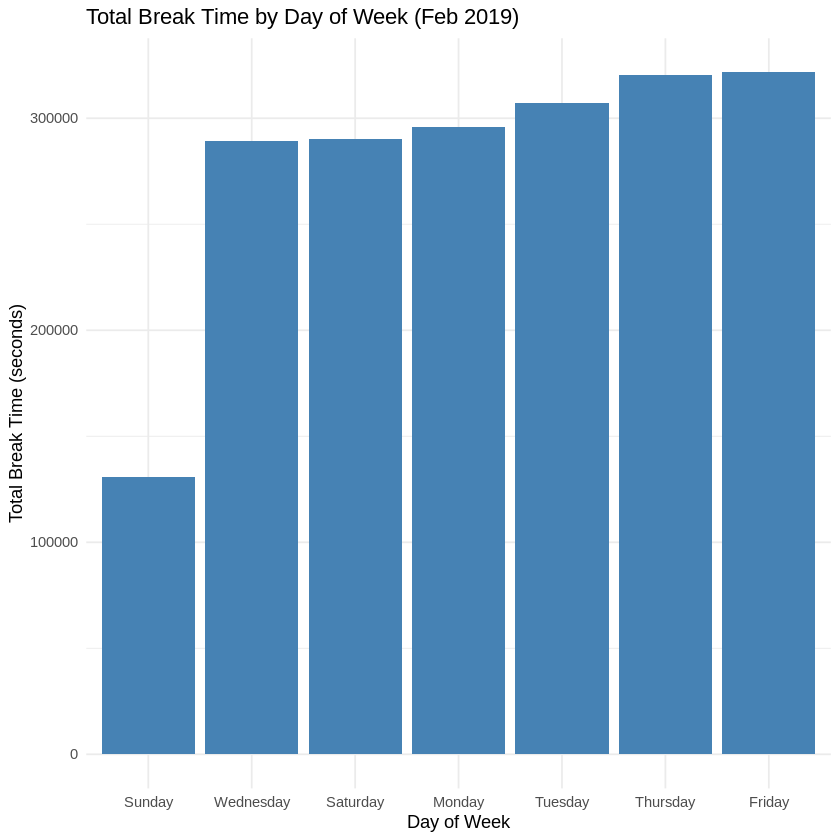

In [256]:
#This provides a day of week view of total break time to understand why there are such high break times in Feb 2019. According to Antczak and Weron(2019) Poland had a policy where stores would close three Sundays of the month starting in 2019.
# filter data for Feb 2019
febData <- txnlogs %>% 
  filter(monthYear == "2019-2")

# calculate total break time by day of week
break_time_by_day <- febData %>%
  group_by(DayOfWeek) %>%
  summarise(total_break_time = sum(BreakTime))

# plot bar graph
ggplot(break_time_by_day, aes(x = reorder(DayOfWeek, total_break_time), y = total_break_time)) +
  geom_bar(stat = "identity", fill = "steelblue") +
  labs(title = "Total Break Time by Day of Week (Feb 2019)",
       x = "Day of Week",
       y = "Total Break Time (seconds)") +
  theme_minimal()


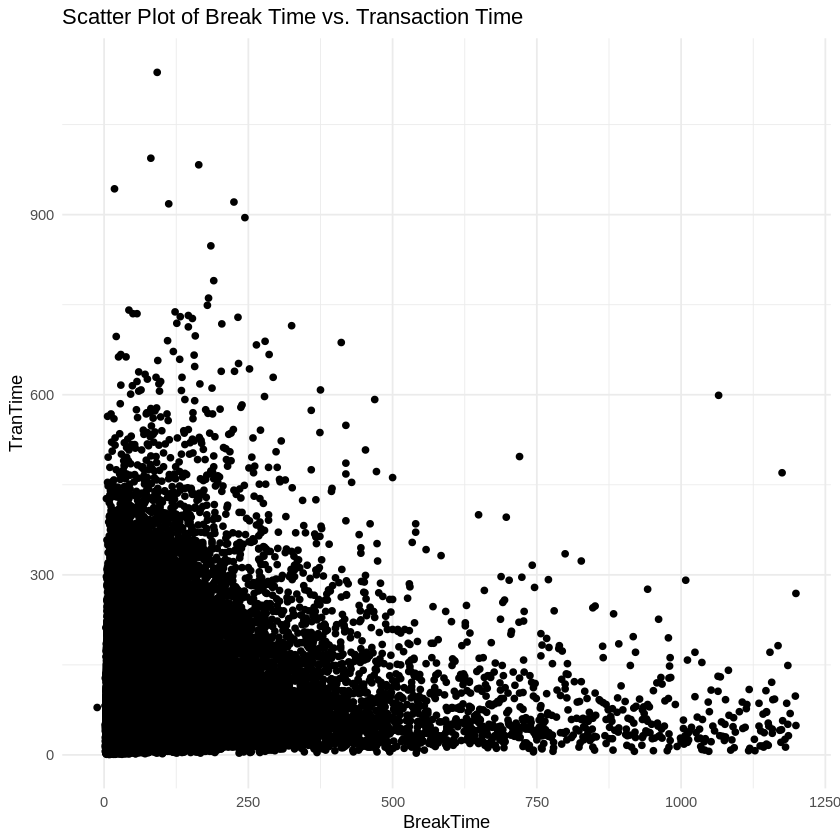

In [299]:
# Scatter plot : Break Time vs. Transaction Time

ggplot(txnlogs, aes(x = BreakTime, y = TranTime)) +
  geom_point() +
  labs(title = "Scatter Plot of Break Time vs. Transaction Time",
       x = "BreakTime",
       y = "TranTime") +
  theme_minimal()

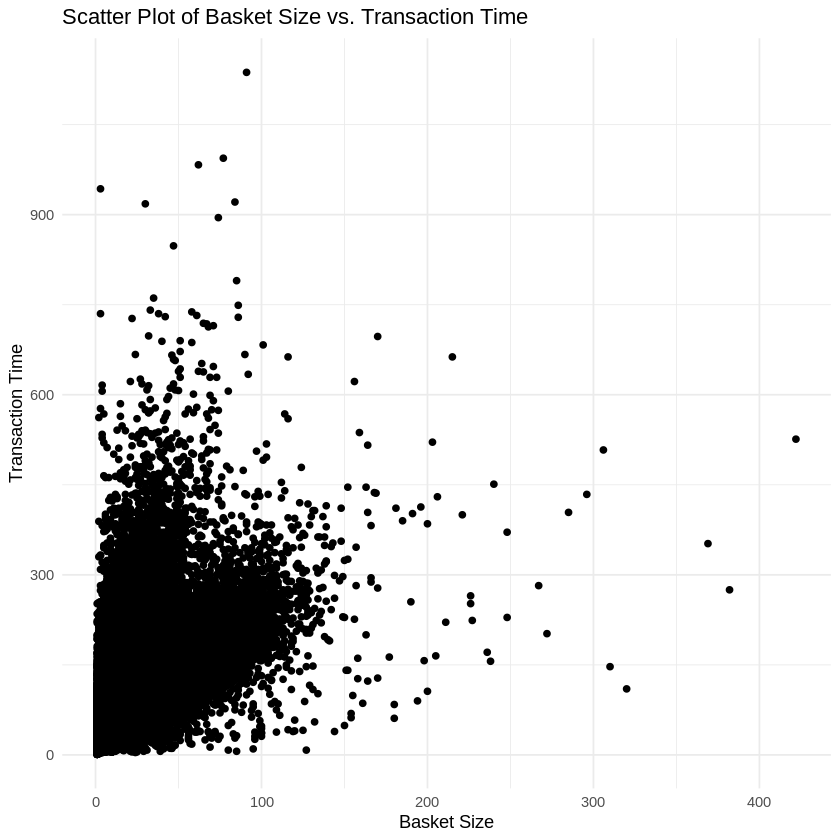

In [300]:
# Scatter plot : Basket Size vs. Transaction Time
ggplot(txnlogs, aes(x = ArtNum, y = TranTime)) +
  geom_point() +
  labs(title = "Scatter Plot of Basket Size vs. Transaction Time",
       x = "Basket Size",
       y = "Transaction Time") +
  theme_minimal()

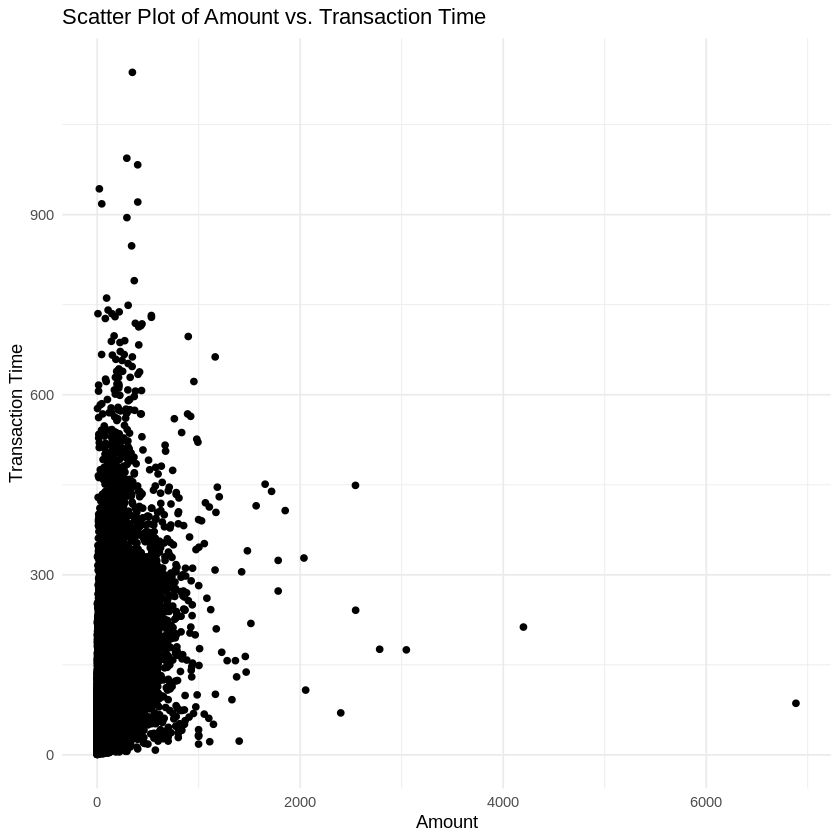

In [301]:
# Scatter plot : Amount vs. Transaction Time
ggplot(txnlogs, aes(x = Amount, y = TranTime)) +
  geom_point() +
  labs(title = "Scatter Plot of Amount vs. Transaction Time",
       x = "Amount",
       y = "Transaction Time") +
  theme_minimal()

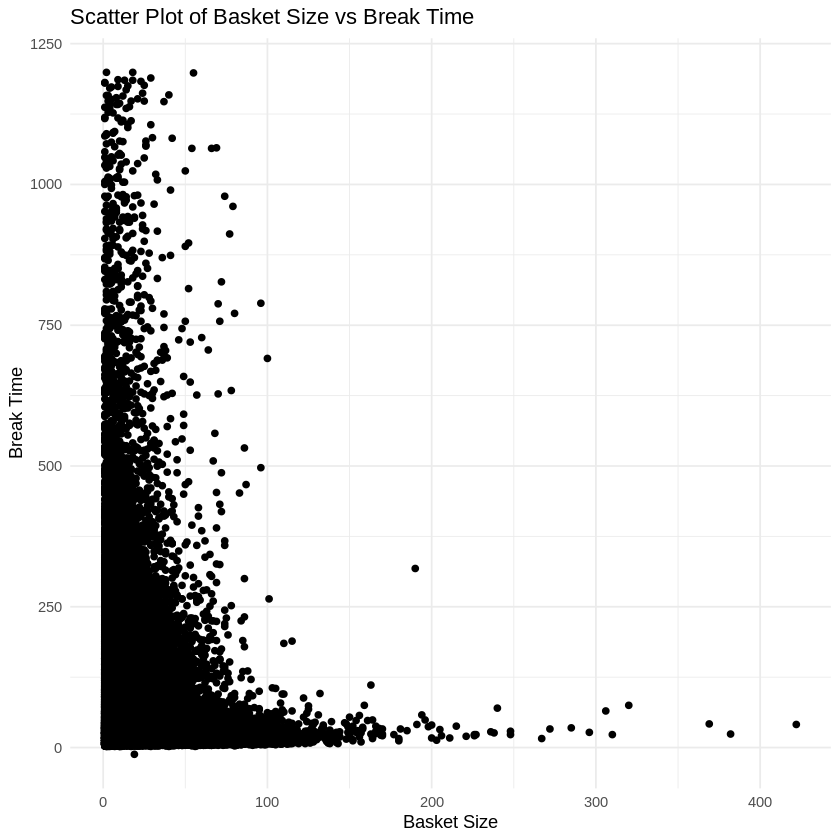

In [302]:
# Scatter plot : Basket Size vs. Break Time
ggplot(txnlogs, aes(x = ArtNum, y = BreakTime)) +
  geom_point() +
  labs(title = "Scatter Plot of Basket Size vs Break Time",
       x = "Basket Size",
       y = "Break Time") +
  theme_minimal()

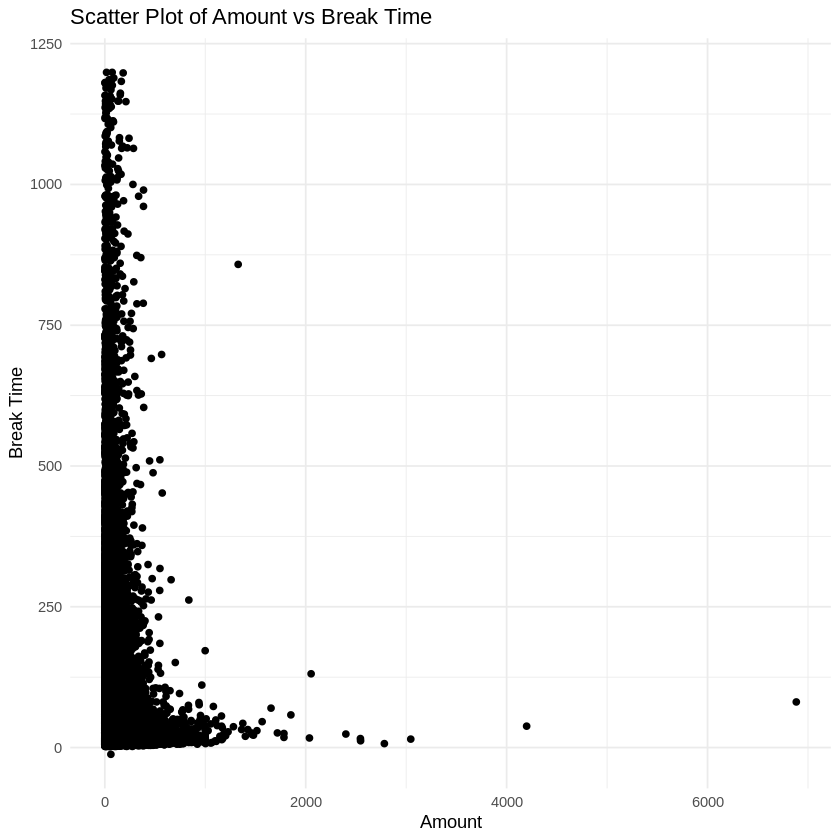

In [303]:
# Scatter plot : Amount vs. Break Time
ggplot(txnlogs, aes(x = Amount, y = BreakTime)) +
  geom_point() +
  labs(title = "Scatter Plot of Amount vs Break Time",
       x = "Amount",
       y = "Break Time") +
  theme_minimal()

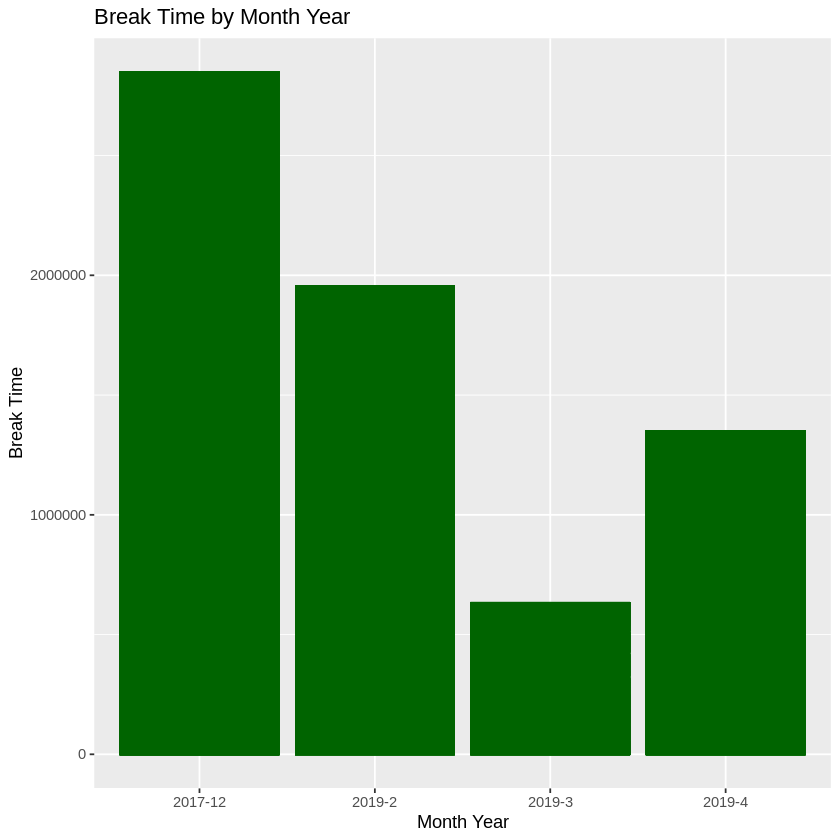

In [136]:
#Break time across all months.

ggplot(txnlogs, aes(x = monthYear, y = BreakTime)) +
  geom_bar(stat = "identity", fill = "steelblue3", color = "darkgreen") +
  ggtitle("Break Time by Month Year") +
  xlab("Month Year") +
  ylab("Break Time")


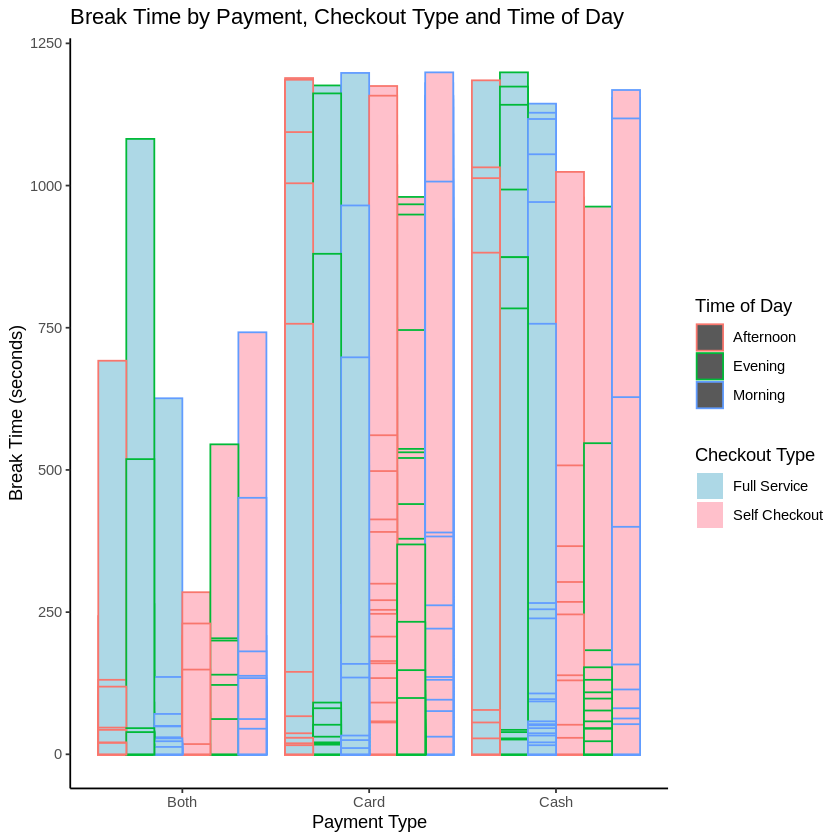

In [72]:
ggplot(txnlogs, aes(x = PaymentType, y = BreakTime, fill = checkoutType, color = timeofDay)) +
  geom_bar(stat = "identity", position = position_dodge()) +
  scale_fill_manual(values = c("light blue", "pink")) +
  labs(title = "Break Time by Payment, Checkout Type and Time of Day ",
       x = "Payment Type", y = "Break Time (seconds)",
       fill = "Checkout Type", color = "Time of Day", size = 50) +
  theme_classic()


In [74]:
#Summary of ArtNum variable. 
summary(txnlogs$ArtNum)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00    5.00   10.00   15.53   20.00  422.00 

In [232]:
#Due to outliers, median was chose as a threshold to observe which months showed basket size more than the median value of 10 items.
library(dplyr)

txnlogs %>%
  filter(ArtNum > 10) %>%
  group_by(monthYear) %>%
  summarise(count = n()) %>%
  mutate(percentage = (count / sum(count)) * 100)


monthYear,count,percentage
<fct>,<int>,<dbl>
2017-12,30933,38.53907
2019-2,23722,29.55497
2019-3,8198,10.21379
2019-4,17411,21.69217


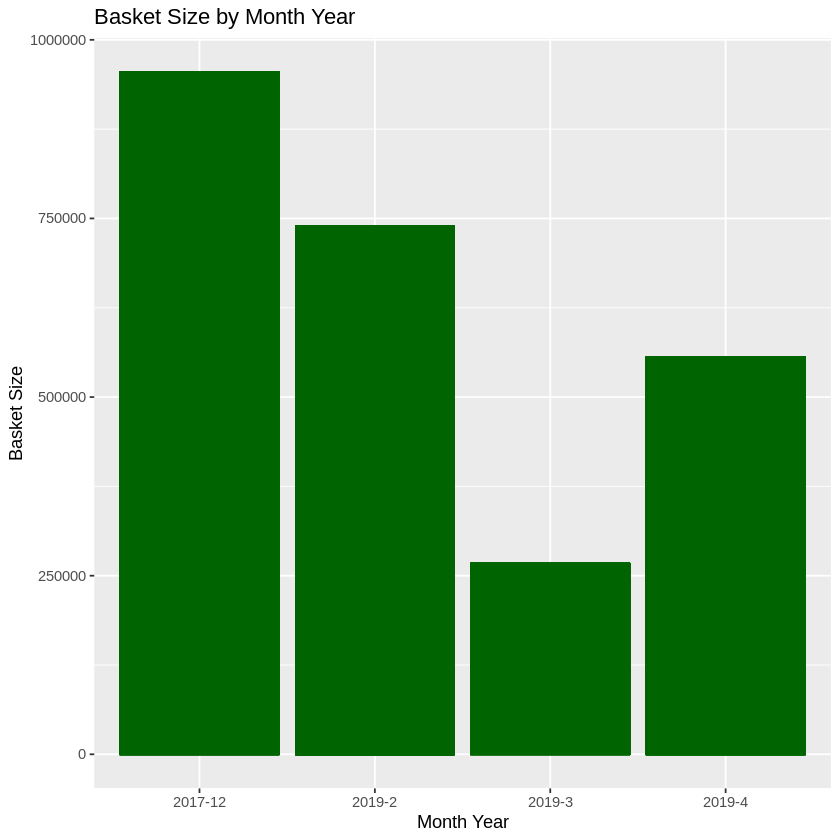

In [144]:
ggplot(txnlogs, aes(x = monthYear, y = ArtNum)) +
  geom_bar(stat = "identity", fill = "steelblue3", color = "darkgreen") +
  ggtitle("Basket Size by Month Year") +
  xlab("Month Year") +
  ylab("Basket Size")


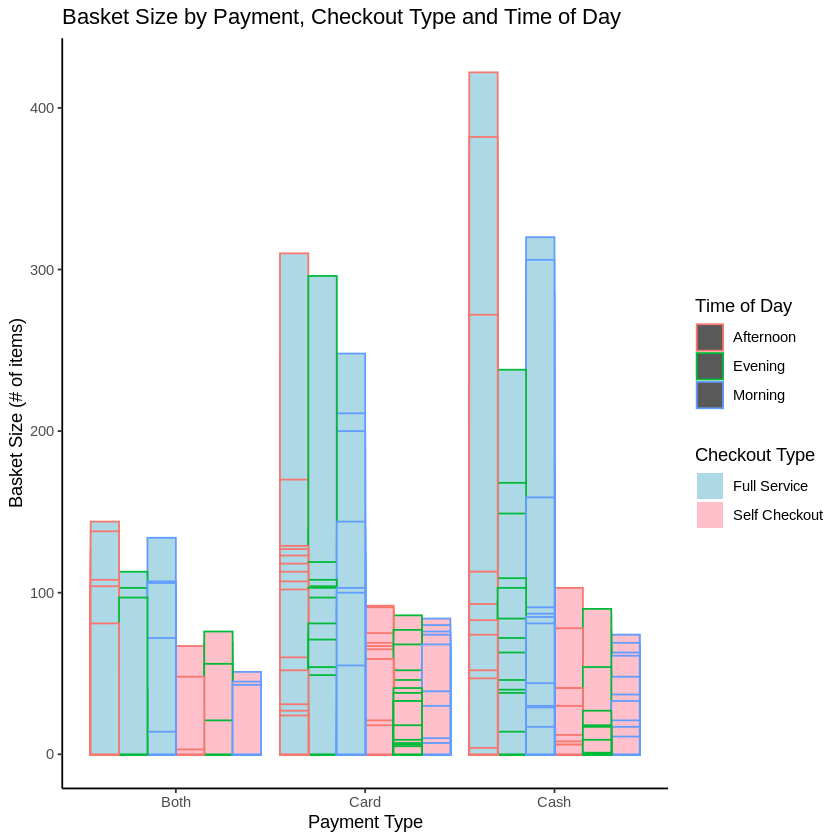

In [146]:
ggplot(txnlogs, aes(x = PaymentType, y = ArtNum, fill = checkoutType, color = timeofDay)) +
  geom_bar(stat = "identity", position = position_dodge()) +
  scale_fill_manual(values = c("light blue", "pink")) +
  labs(title = "Basket Size by Payment, Checkout Type and Time of Day ",
       x = "Payment Type", y = "Basket Size (# of items)",
       fill = "Checkout Type", color = "Time of Day", size = 50) +
  theme_classic()


Analysis and Visualization (Categorical Variables)

Warning message in plot.window(xlim, ylim, log = log, ...):
“"title" is not a graphical parameter”
Warning message in axis(if (horiz) 2 else 1, at = at.l, labels = names.arg, lty = axis.lty, :
“"title" is not a graphical parameter”
Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“"title" is not a graphical parameter”
Warning message in axis(if (horiz) 1 else 2, cex.axis = cex.axis, ...):
“"title" is not a graphical parameter”


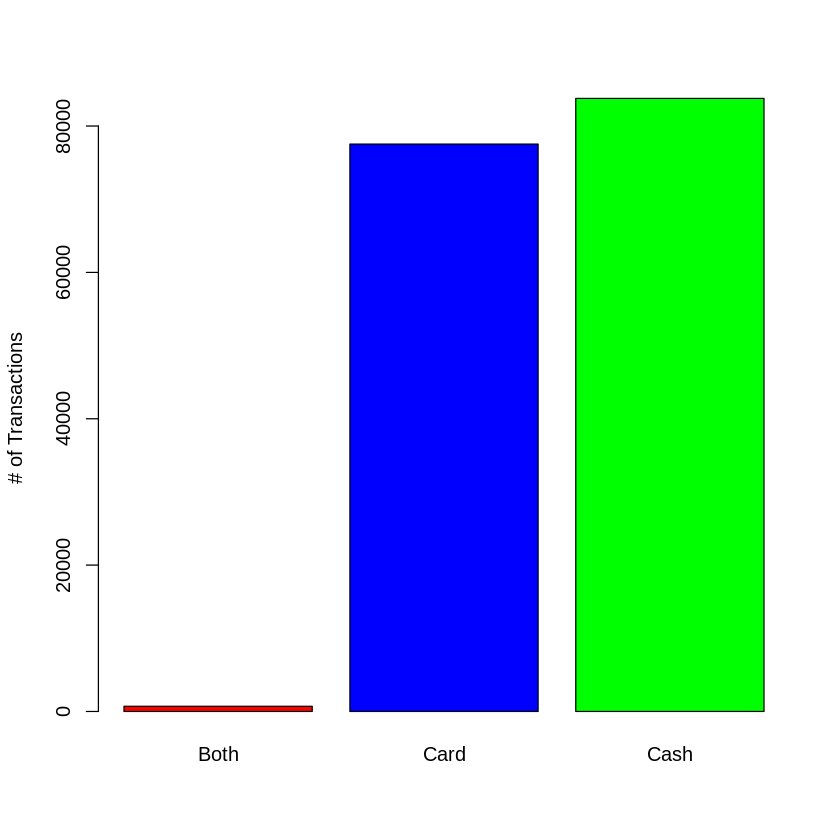

In [153]:
#Payment type plotted against the # of transactions. Cash is a more popular payment type across all months
my_colors <- c("red", "blue", "green")
barplot(table(txnlogs$PaymentType), ylab = '# of Transactions', title="Payment Types", col = my_colors)


Warning message in plot.window(xlim, ylim, log = log, ...):
“"title" is not a graphical parameter”
Warning message in axis(if (horiz) 2 else 1, at = at.l, labels = names.arg, lty = axis.lty, :
“"title" is not a graphical parameter”
Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“"title" is not a graphical parameter”
Warning message in axis(if (horiz) 1 else 2, cex.axis = cex.axis, ...):
“"title" is not a graphical parameter”


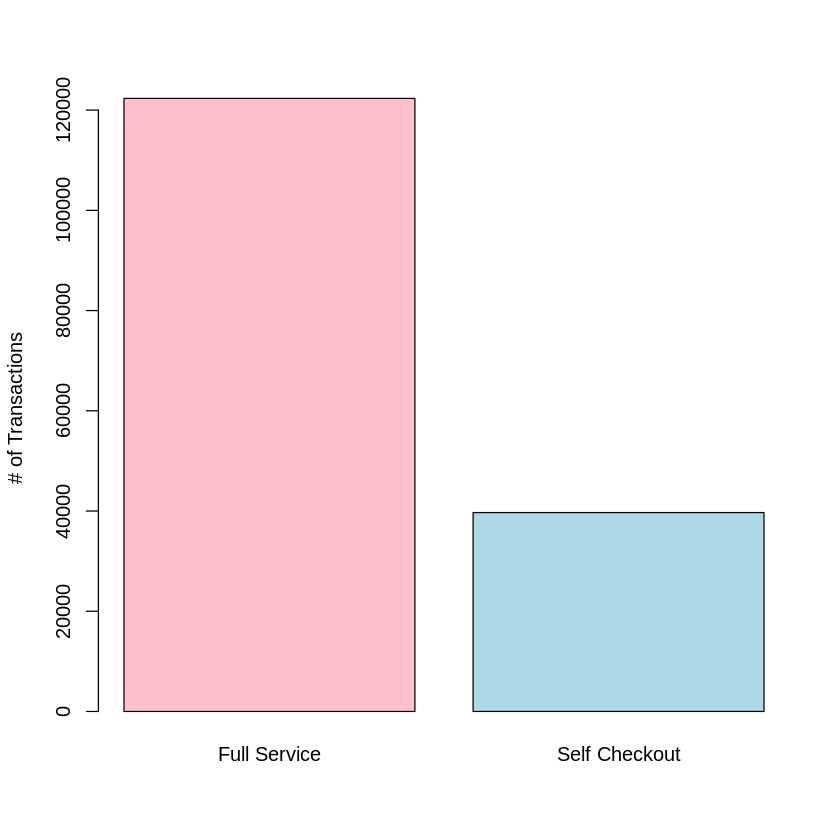

In [156]:
#Checkout type plotted against the # of transactions. Full service is a more popular checkout type across all months
my_colors <- c("pink",  "light blue")
barplot(table(txnlogs$checkoutType), ylab = '# of Transactions', title="Checkout Types", col = my_colors)


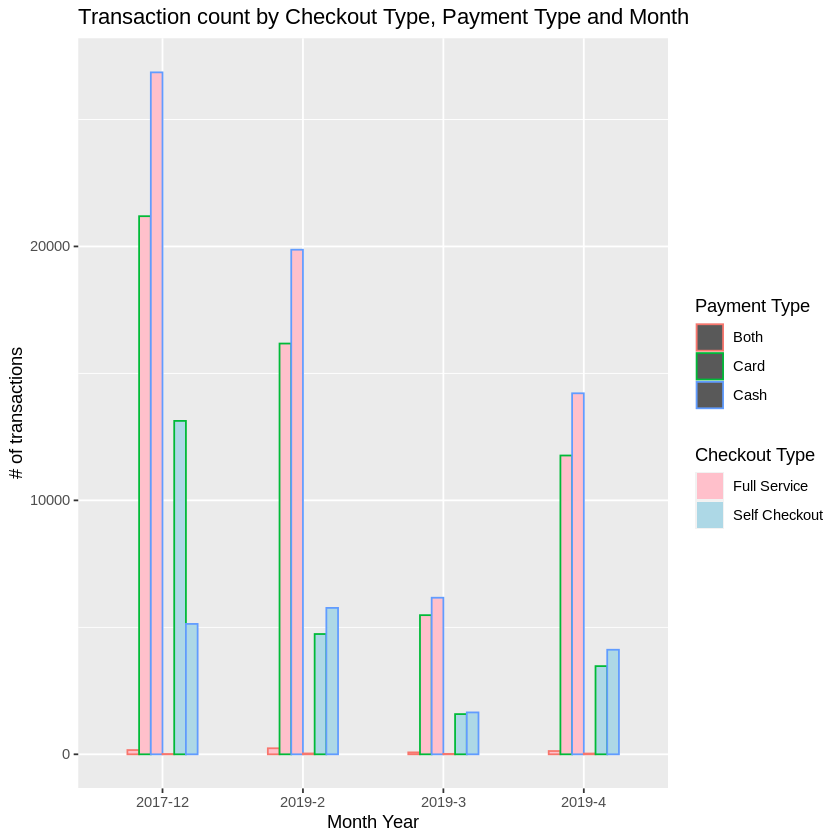

In [306]:
ggplot(txnlogs, aes(x = monthYear, fill = checkoutType, color = PaymentType)) +
  geom_bar(width = 0.5, position = "dodge") +
  scale_fill_manual(values = c("pink", "light blue")) +
  labs(title = "Transaction count by Checkout Type, Payment Type and Month", x = "Month Year", y = "# of transactions", fill = "Checkout Type", color = "Payment Type")


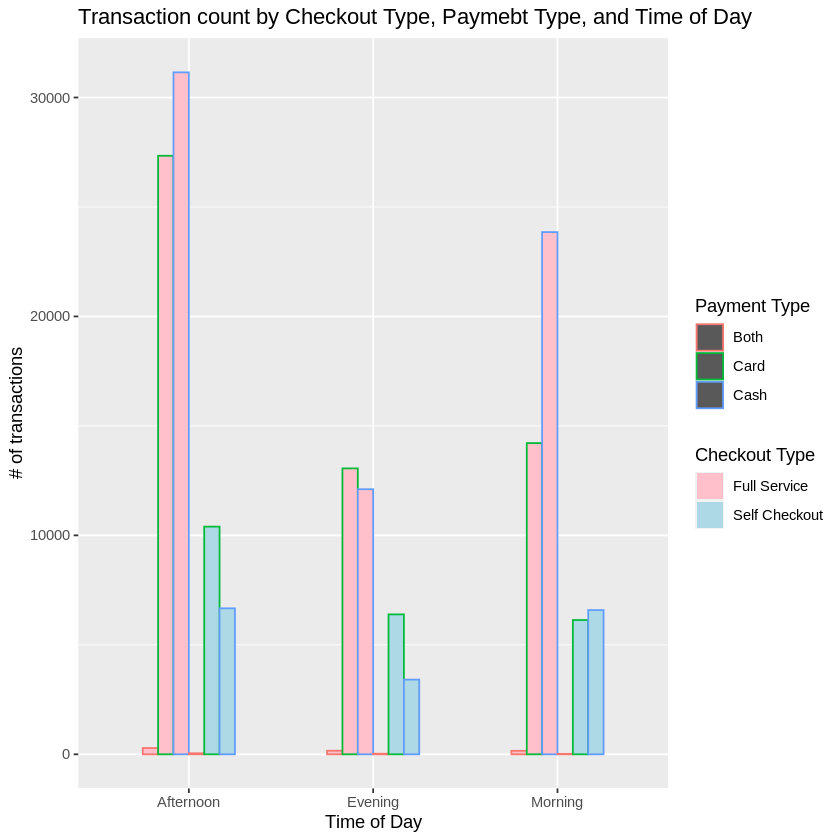

In [307]:
ggplot(txnlogs, aes(x = timeofDay, fill = checkoutType, color = PaymentType)) +
  geom_bar(width = 0.5, position = "dodge") +
  scale_fill_manual(values = c("pink", "light blue")) +
  labs(title = "Transaction count by Checkout Type, Paymebt Type, and Time of Day", x = "Time of Day", y = "# of transactions", fill = "Checkout Type", color = "Payment Type")


Linear Regression Analysis

In [312]:
#create dummy variables
library(dplyr)

# Create dummy variables for PaymentType
txnlogs <- txnlogs %>% 
  mutate(PaymentTypeDummy = ifelse(PaymentType == "Card", 1, 0))

# Create dummy variables for CheckoutType
txnlogs <- txnlogs %>% 
  mutate(CheckoutTypeDummy = ifelse(checkoutType == "Self Checkout", 1, 0))


In [313]:
#Correlation matrix dataset for linear regression model

dfLinReg <- data.frame(txnlogs$PaymentTypeDummy, txnlogs$CheckoutTypeDummy, txnlogs$ArtNum, txnlogs$logTranTime, txnlogs$BreakTime, txnlogs$Amount)

In [314]:
#Correlation matrix 
res <- cor(dfLinReg)
round(res, 2)

,txnlogs.PaymentTypeDummy,txnlogs.CheckoutTypeDummy,txnlogs.ArtNum,txnlogs.logTranTime,txnlogs.BreakTime,txnlogs.Amount
txnlogs.PaymentTypeDummy,1.00,0.11,0.16,0.26,0.01,0.16
txnlogs.CheckoutTypeDummy,0.11,1.00,-0.23,0.25,0.40,-0.19
txnlogs.ArtNum,0.16,-0.23,1.00,0.60,-0.07,0.78
txnlogs.logTranTime,0.26,0.25,0.60,1.00,0.13,0.52
txnlogs.BreakTime,0.01,0.40,-0.07,0.13,1.00,-0.06
txnlogs.Amount,0.16,-0.19,0.78,0.52,-0.06,1.00


In [324]:
model <- lm(logTranTime ~ ArtNum + PaymentTypeDummy + CheckoutTypeDummy + ArtNum + BreakTime + Amount, data = txnlogs)
summary(model)


Call:
lm(formula = logTranTime ~ ArtNum + PaymentTypeDummy + CheckoutTypeDummy + 
    ArtNum + BreakTime + Amount, data = txnlogs)

Residuals:
     Min       1Q   Median       3Q      Max 
-10.0573  -0.2977   0.0611   0.3592   2.8496 

Coefficients:
                    Estimate Std. Error t value            Pr(>|t|)    
(Intercept)       3.15818743 0.00251642 1255.03 <0.0000000000000002 ***
ArtNum            0.02809350 0.00013854  202.78 <0.0000000000000002 ***
PaymentTypeDummy  0.16530975 0.00288977   57.20 <0.0000000000000002 ***
CheckoutTypeDummy 0.72357295 0.00369835  195.65 <0.0000000000000002 ***
BreakTime         0.00028252 0.00002125   13.29 <0.0000000000000002 ***
Amount            0.00132248 0.00002576   51.34 <0.0000000000000002 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.5651 on 162019 degrees of freedom
Multiple R-squared:  0.527,	Adjusted R-squared:  0.527 
F-statistic: 3.61e+04 on 5 and 162019 DF,  p-value: < 0.0000

In [315]:
#Split dataset into train and test rows
library(caret)
set.seed(123) # for reproducibility
trainIndex <- createDataPartition(txnlogs$logTranTime, p = .8, list = FALSE)
txnlogsTrain <- txnlogs[trainIndex, ]
txnlogsTest <- txnlogs[-trainIndex, ]

In [320]:
#Train the linear model against the train data. 
model <- lm(logTranTime ~ ArtNum + PaymentTypeDummy + CheckoutTypeDummy + ArtNum + BreakTime + Amount, data = txnlogsTrain)

In [321]:
#Test our model and display the mean squared error. Since the value is low, we can conclude that our model performs well at predicting transaction values using the independent variables
predictions <- predict(model, newdata = txnlogsTest)
mse <- mean((txnlogsTest$logTranTime - predictions)^2)
mse
summary(predictions)

[1] 0.3124073

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  3.189   3.504   3.870   3.955   4.245  12.623 

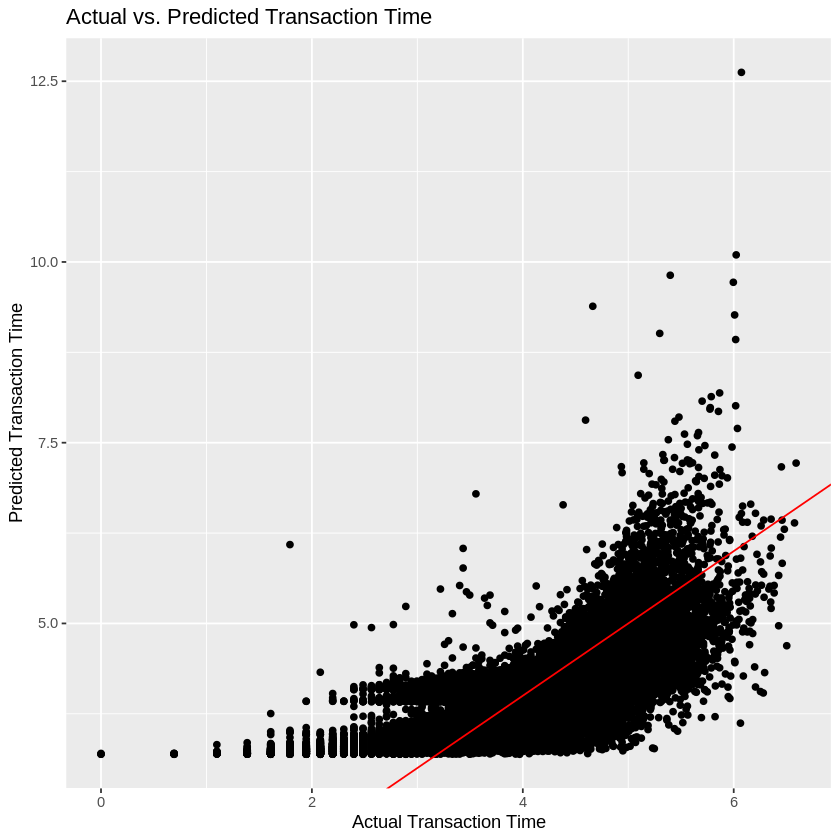

In [322]:
# Plot predicted values against actual values. The plot shows that the model does well at predicting smaller transaction times vs larger. The choice to keep larger transaction times is noticeable in the outliers found in this comparison plot. 
library(ggplot2)
ggplot(data.frame(Actual = txnlogsTest$logTranTime, Predicted = predictions), aes(x = Actual, y = Predicted)) +
  geom_point() +
  geom_abline(intercept = 0, slope = 1, color = "red") +
  labs(title = "Actual vs. Predicted Transaction Time", x = "Actual Transaction Time", y = "Predicted Transaction Time")
